In [6]:
from collections import OrderedDict

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import shapely.affinity
from matplotlib.ticker import MultipleLocator
from skfem import Basis, ElementTriP0, Functional
from skfem.io.meshio import from_meshio

from femwell.maxwell.waveguide import compute_modes
from femwell.mesh import mesh_from_OrderedDict

In [7]:
wavelength = 1.55
capital_w = 1.4
capital_h = 0.3
h_list = [0.5, 0.7]
t = 0.1
n_silicon = 3.48
n_air = 1
n_nc = 1.6
n_silica = 1.45
w_list = [x for x in range(250, 700, 100)]
neff_dict = dict()
aeff_dict = dict()
aeff1_dict = dict()
aeff3_dict = dict()
tm_dict = dict()
p_dict = dict()
for h in h_list:
    neff_list = []
    aeff_list = []
    aeff1_list = []
    aeff3_list = []
    tm_list = []
    p_list = []
    for width in w_list:
        width = width * 1e-3
        nc = shapely.geometry.box(
            -width / 2, capital_h + (h - t) / 2, +width / 2, capital_h + (h - t) / 2 + t
        )
        silica = shapely.geometry.box(-capital_w / 2, 0, +capital_w / 2, capital_h)
        silicon = shapely.geometry.box(-width / 2, capital_h, +width / 2, capital_h + h)

        polygons = OrderedDict(
            core=nc,
            silicon=silicon,
            silica=silica,
            air=nc.buffer(10.0, resolution=4),
        )

        resolutions = dict(
            core={"resolution": 0.02, "distance": 0.3},
            silicon={"resolution": 0.02, "distance": 0.1},
            silica={"resolution": 0.04, "distance": 0.5},
        )

        mesh = from_meshio(mesh_from_OrderedDict(polygons, resolutions, default_resolution_max=2))

        basis0 = Basis(mesh, ElementTriP0())
        epsilon = basis0.zeros()
        for subdomain, n in {
            "core": n_nc,
            "silicon": n_silicon,
            "air": n_air,
            "silica": n_silica,
        }.items():
            epsilon[basis0.get_dofs(elements=subdomain)] = n**2
        modes = compute_modes(basis0, epsilon, wavelength=wavelength, num_modes=3, order=1)

        for mode in modes:
            if mode.tm_fraction > 0.5:
                # mode.show("E", part="real")
                print(f"Effective refractive index: {mode.n_eff:.4f}")
                print(f"Effective mode area: {mode.calculate_effective_area(field='y'):.4f}")
                print(f"Mode transversality: {mode.transversality}")
                neff_list.append(np.real(mode.n_eff))
                aeff_list.append(mode.calculate_effective_area())
                tm_list.append(mode.transversality)
                p_list.append(mode.Sz)

                @Functional
                def I(w):
                    return 1

                @Functional
                def Sz(w):
                    return w["Sz"]

                @Functional
                def Sz2(w):
                    return w["Sz"] ** 2

                Sz_basis, Sz_vec = mode.Sz

                int_Sz = Sz.assemble(Sz_basis, Sz=Sz_basis.interpolate(Sz_vec))
                print("int(Sz)", int_Sz)  # 1 as it's normalized
                int_I = I.assemble(Sz_basis.with_elements("core"))
                print("int_core(1)", int_I)  # area of core

                int_Sz_core = Sz.assemble(
                    Sz_basis.with_elements("core"),
                    Sz=Sz_basis.with_elements("core").interpolate(Sz_vec),
                )
                print(
                    "int_core(Sz)",
                    int_Sz_core,
                )
                int_Sz2 = Sz2.assemble(Sz_basis, Sz=Sz_basis.interpolate(Sz_vec))
                print("int(Sz^2)", int_Sz2)

                aeff1_list.append(int_Sz**2 / int_Sz2)
                aeff3_list.append(int_I * int_Sz / int_Sz_core)
                break
        else:
            print(f"no TM mode found for {width}")
    neff_dict[str(h)] = neff_list
    aeff1_dict[str(h)] = aeff1_list
    aeff_dict[str(h)] = aeff_list
    aeff3_dict[str(h)] = aeff3_list
    tm_dict[str(h)] = tm_list
    p_dict[str(h)] = p_list
    
    clear_output()

In [10]:
# Ivan D. Rukhlenko, Malin Premaratne, and Govind P. Agrawal. Effective mode area and its optimization in silicon-nanocrystal waveguides. 
# Optics Letters, 37(12):2295, June 2012. URL: http://dx.doi.org/10.1364/OL.37.002295, doi:10.1364/ol.37.002295.

C:\Users\blow\AppData\Local\anaconda3\Lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


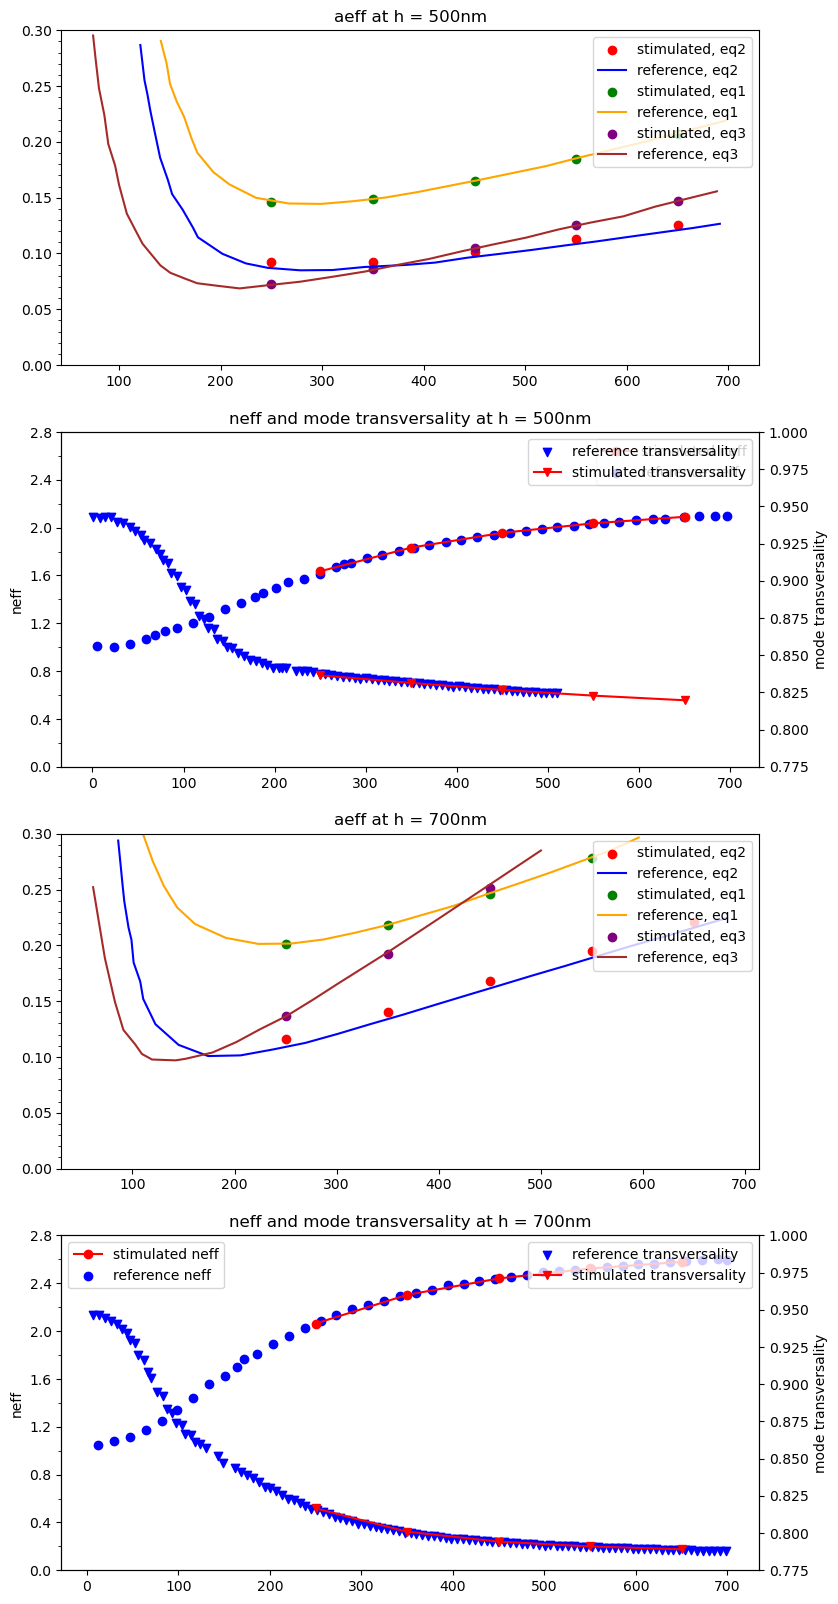

In [9]:
path = "./reference_data/Rukhlenko"

fig, axs = plt.subplots(4, 1, figsize=(9, 20))

for t1, t2, ax1, ax2 in [("0.5", "500", *axs[0:2]), ("0.7", "700", *axs[2:4])]:
    reference_neff = np.loadtxt(path + f"/fig_1c_neff/h_{t2}nm.csv", delimiter=",")
    reference_aeff1 = np.loadtxt(path + f"/fig_1b_aeff/{t1}_Eq1.csv", delimiter=",")
    reference_aeff2 = np.loadtxt(path + f"/fig_1b_aeff/{t1}_Eq2.csv", delimiter=",")
    reference_aeff3 = np.loadtxt(path + f"/fig_1b_aeff/{t1}_Eq3.csv", delimiter=",")
    reference_tm = np.loadtxt(path + f"/fig_1c_neff/tm_h_{t2}nm.csv", delimiter=",")

    ax1.scatter(w_list, aeff_dict[t1], c="r", label="stimulated, eq2")
    ax1.plot(reference_aeff2[:, 0], reference_aeff2[:, 1], c="b", label="reference, eq2")

    ax1.scatter(w_list, aeff1_dict[t1], c="green", label="stimulated, eq1")
    ax1.plot(reference_aeff1[:, 0], reference_aeff1[:, 1], c="orange", label="reference, eq1")

    ax1.scatter(w_list, aeff3_dict[t1], c="purple", label="stimulated, eq3")
    ax1.plot(reference_aeff3[:, 0], reference_aeff3[:, 1], c="brown", label="reference, eq3")

    ax1.set_title(f"aeff at h = {t2}nm")
    ax1.yaxis.set_major_locator(MultipleLocator(0.05))
    ax1.yaxis.set_minor_locator(MultipleLocator(0.01))
    ax1.set_ylim(0, 0.3)
    ax1.legend(loc="upper right")

    ax2b = ax2.twinx()
    ax2b.set_ylabel("mode transversality")
    ax2b.scatter(
        reference_tm[:, 0],
        reference_tm[:, 1],
        marker="v",
        c="b",
        label="reference transversality",
    )
    ax2b.plot(w_list, tm_dict[t1], "-v", c="r", label="stimulated transversality")
    ax2b.set_ylim(0.775, 1)
    ax2b.legend()

    ax2.plot(w_list, neff_dict[t1], "-o", c="r", label="stimulated neff")
    ax2.scatter(reference_neff[:, 0], reference_neff[:, 1], c="b", label="reference neff")
    ax2.set_title(f"neff and mode transversality at h = {t2}nm")
    ax2.set_ylabel("neff")
    ax2.yaxis.set_major_locator(MultipleLocator(0.4))
    ax2.yaxis.set_minor_locator(MultipleLocator(0.2))
    ax2.set_ylim(0, 2.8)
    ax2.legend()

plt.show()

In [ ]:
# Data figure h
w_fig_h = 500
idx_fig_h = min(range(len(w_list)), key=lambda x: abs(w_list[x] - w_fig_h))
h_fig_h = 0.7
basis_fig_h, Pz_fig_h = p_dict[str(h_fig_h)][idx_fig_h]

# Data figure f
w_fig_f = 600
idx_fig_f = min(range(len(w_list)), key=lambda x: abs(w_list[x] - w_fig_f))
h_fig_f = 0.5
basis_fig_f, Pz_fig_f = p_dict[str(h_fig_f)][idx_fig_f]

fig, ax = plt.subplots(1, 2)

basis_fig_h.plot(np.abs(Pz_fig_h), ax=ax[0], aspect="equal")
ax[0].set_title(
    f"Poynting vector $S_z$\nfor h = {h_fig_h}μm & w = {w_fig_h}nm\n(Reproduction of Fig.1.h)"
)
ax[0].set_xlim(-w_fig_h * 1e-3 / 2 - 0.1, w_fig_h * 1e-3 / 2 + 0.1)
ax[0].set_ylim(capital_h - 0.1, capital_h + h_fig_h + 0.1)
# Turn off the axis wrt to the article figure
ax[0].axis("off")
# Add the contour
for subdomain in basis_fig_h.mesh.subdomains.keys() - {"gmsh:bounding_entities"}:
    basis_fig_h.mesh.restrict(subdomain).draw(
        ax=ax[0], boundaries_only=True, color="k", linewidth=1.0
    )

basis_fig_f.plot(np.abs(Pz_fig_f), ax=ax[1], aspect="equal")
ax[1].set_title(
    f"Poynting vector $S_z$\nfor h = {h_fig_f}μm & w = {w_fig_f}nm\n(Reproduction of Fig.1.f)"
)
ax[1].set_xlim(-w_list[idx_fig_f] * 1e-3 / 2 - 0.1, w_list[idx_fig_f] * 1e-3 / 2 + 0.1)
ax[1].set_ylim(capital_h - 0.1, capital_h + h_fig_f + 0.1)
# Turn off the axis wrt to the article figure
ax[1].axis("off")
# Add the contour
for subdomain in basis_fig_f.mesh.subdomains.keys() - {"gmsh:bounding_entities"}:
    basis_fig_f.mesh.restrict(subdomain).draw(
        ax=ax[1], boundaries_only=True, color="k", linewidth=1.0
    )

fig.tight_layout()
plt.show()